In [169]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from itertools import product
from collections import Counter

from joblib import Parallel, delayed

In [16]:
#COLORS
colors = {'blue':'#1985A1', 'red':'#F04941', 'dark':'#232A33'}

#IMPORT DATA
df = pd.read_csv('Data/all_codas.csv')
#remove rows with no timestep info
df = df[~df['TsTo'].isna()]

#REMOVE UNNECESSARY COLUMNS
data = df.iloc[:, np.r_[56,5:45]].values
rows,cols = np.where(data!=0)
#make timesteps start at 0
data[:,0]=data[:,0]-data[:,0].min()
data[:,1:]=data[:,1:]+data[:,0][:,None]

#CLEAN DATA
clicks = np.empty(shape=(rows.shape[0],4))
i=0
for row,col in zip(rows,cols):
    clicks[i,:]=[df.index[row],data[row,col],
                       df[df.index==df.index[row]].Whale.values[0],
                       df[df.index==df.index[row]].Bout.values[0]]
    i+=1
clicks = pd.DataFrame(clicks,columns=['coda_index','time','whale','bout']).sort_values('time').reset_index(drop=True)

#GET ICI (delta_t) for each whale
from_own_clicks = np.empty(len(clicks))

for whale in clicks['whale'].unique():
    mask = clicks['whale']==whale
    own_df = clicks[mask]

    #get diff from own clicks
    from_own_clicks[mask] = own_df.time.diff()

clicks['delta_t'] = from_own_clicks

/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (46,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [185]:
class MCM:
    def __init__(self, depth, whale=1, horizon=1.5, resolution=0.02):
        self.depth = depth
        self.whale = whale
        self.horizon = horizon
        self.resolution = resolution
    
    def fit(self, clicks,entropy_toggle=True):
        
        #1. PROCESS DATASET
        frame = clicks[clicks['whale']==self.whale]
        #separate where ICI > horizon
        ids = np.argwhere((frame['delta_t']>self.horizon).values).flatten()
        blocks=[]
        i=1
        for j in ids:
            blocks.append(frame.iloc[i:j]['delta_t'].values)
            i=j+1

        #remove empty blocks
        blocks = [block for block in blocks if len(block)>0]
        
        #2. DISCRETIZE
        bins = np.arange(0,self.horizon+self.resolution,self.resolution)
        self.n_params = len(bins) 
        self.positions = [np.digitize(block,bins) for block in blocks]
        
        # divide blocks into sets of h+1 clicks: 
        #Example h=2: [1,5,3,2] -> [1,5,3],[5,3,2]
        temp,skipped = [],0
        for position in self.positions: 
            if len(position)>=self.depth: #jumps over blocks with less clicks than memory
                temp.extend([list(a) for a in rolling_window(position,self.depth)])
                skipped+=1
        self.skipped = 1- (skipped/len(self.positions))
        temp = np.array(temp)
        
        #3. PROBABILITY ESTIMATION p(y|x)
        #Count ocurrences  (x,y)
        ux, idsx,csx =np.unique(temp,return_counts=True,return_inverse=True,axis=0)
        #Count ocurrences of (x)
        u, ids,cs = np.unique(ux[:,:-1],return_counts=True,return_inverse=True,axis=0)

        #arrange into a 2d array (N) where Column1: occurences of (x) and Column2: occurences of (x,y)
        ncs = np.array([np.sum((temp[:,:-1]==unu).all(axis=1)) for unu in u])
        self.nodes = ux
        self.N = np.c_[ncs[ids],csx]
        
        #adjacency_matrix A        
        self.F = len(temp) #total number of occurences (to get frequency to get entropy)
        self.A = np.zeros(shape=(len(u),self.n_params))
        if entropy_toggle:
            for i in range(len(ux)): #aij = H(i|j)
                self.A[ids[i],ux[i,-1]] = -(self.N[i,1]/self.F)*np.log2(self.N[i,1]/self.N[i,0])
        else:
            for i in range(len(ux)): #aij = p(i|j)
                self.A[ids[i],ux[i,-1]] = self.N[i,1]/self.N[i,0]
        
        #order or nodes in matrix A
        self.memories = u
        #maximum likelyhood estimation (used for BIC and AIC)
        self.MLE = -np.sum(np.log2(self.N[:,1]/self.N[:,0])*self.N[:,1])    
        return self
    

    
    def BIC(self,observed=True):
        """
        calculates Bayesian Information criterion.
        observed: bool
            True: uses the total number of states as the number of parameters.
            False: uses (M-1)*M^h where h is memory and M is the number of bins. 
                    Which is !very! high values and most cases causes floating point errors 
                    for h > 4.     
        """
        if observed:
            return 2*self.MLE + np.log2(self.N[:,0].sum())*self.N.shape[0]
        else:
            M = (self.n_params-1)*(self.n_params**(self.depth-1))
            return 2*self.MLE + np.log2(self.N[:,0].sum())*M
        
    def AIC(self,observed=True):
        """
        calculates Akike Information criterion.
        observed: bool
            True: uses the total number of states as the number of parameters.
            False: uses (M-1)*M^h where h is memory and M is the number of bins. 
                    Which is !very! high values and most cases causes floating point errors 
                    for h > 4.     
        """
        if observed:
            return 2*self.MLE + 2*self.N.shape[0]
        else:
            M = (self.n_params-1)*(self.n_params**(self.depth-1))
            return 2*self.MLE + 2*M

#AUX functions
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# Parameters

In [38]:
resolutions = [0.001,0.02,0.07,0.1]
depths = np.arange(1,11)
horizon = 1.5
whale = 1

## BIC and AIC

In [61]:
bic,aic= [],[]
for resolution in resolutions:
    inner_bic,inner_aic=[],[]
    for depth in depths:
        
        model = MCM(depth=depth,resolution=resolution,
                    horizon=horizon,whale=whale).fit(clicks)
    
        inner_bic.append(model.BIC()); inner_aic.append(model.AIC())
    bic.append(inner_bic); aic.append(inner_aic)


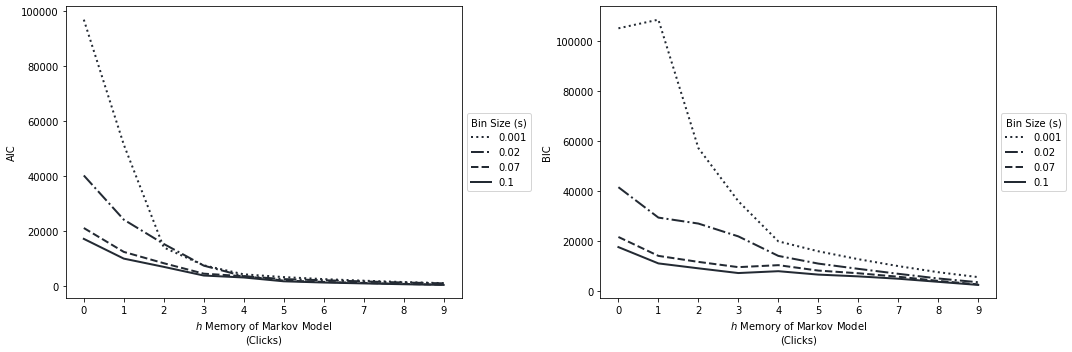

In [30]:
plt.figure(figsize=(15,5))
for i,label,series in zip(range(1,3),['AIC', 'BIC'],[aic,bic]):
    plt.subplot(1,2,i)

    for values,resolution,linestyle in zip(series,resolutions,[':','-.','--','-']):
        plt.plot(depths-1,values,label=np.round(resolution,3),
                 color=colors['dark'],linestyle=linestyle,linewidth=2)
    plt.xlabel('$h$ Memory of Markov Model\n(Clicks)')
    plt.ylabel(label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Bin Size (s)')
    plt.xticks(depths-1)
    plt.tight_layout()
    #plt.savefig('perm_images/AIC',dpi=200)
plt.show()

## Entropy: Mean and Variance

$$
H(Y=y|X) = -\sum_{i\in X} p(x_i,y)\log_2\left(\frac{p(x_i,y)}{p(x_i)}\right)
$$

In [176]:
variances,means=[],[]
for resolution in resolutions:
    inner_variances,inner_means=[],[]
    for depth in depths:
    
        model = MCM(depth=depth,resolution=resolution,
                        horizon=horizon,whale=whale).fit(clicks,entropy_toggle=False) #entropy_toggle = FALSE!

        inner_variances.append(np.var(model.A,axis=0,where=model.A!=0)) #carefull with zero entries in matrix A!!
        inner_means.append(np.mean(model.A,axis=0,where=model.A!=0))
    variances.append(inner_variances);means.append(inner_means)

/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


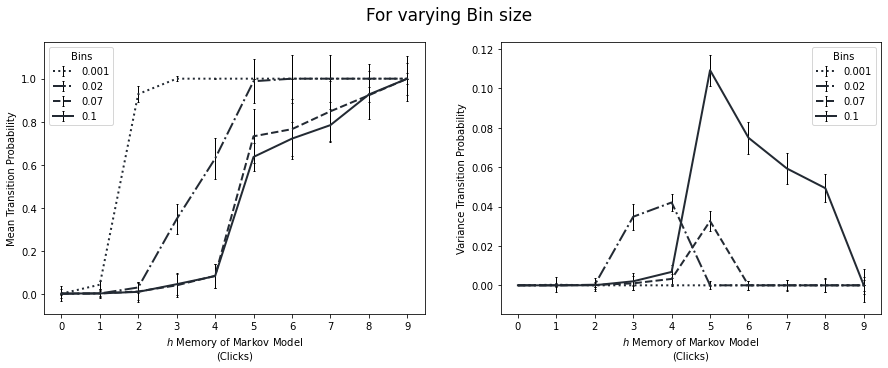

In [177]:
plt.figure(figsize=(15,5))
for i,label,series in zip(range(1,3),['Mean', 'Variance'],[means,variances]):
    plt.subplot(1,2,i)
    
    for values,resolution,linestyle in zip(series,resolutions,[':','-.','--','-']):

        plt.errorbar(depths-1, np.nanmedian(values,axis=1), yerr = np.nanvar(values,axis=1),
                     capsize=1, ecolor='k',elinewidth=1,linewidth=2,color=colors['dark'],
                     label=np.round(resolution,3),linestyle=linestyle)
        
    plt.xticks(depths-1)
    plt.legend(title='Bins')
    plt.ylabel(f'{label} Transition Probability')
    plt.xlabel('$h$ Memory of Markov Model\n(Clicks)')
plt.suptitle('For varying Bin size',fontsize=17)
plt.show()

In [179]:
variances,means=[],[]
for horizon_ in [0.75,1.5,3,6]:
    inner_variances,inner_means=[],[]
    for depth in depths:
    
        model = MCM(depth=depth,resolution=0.02,
                        horizon=horizon_,whale=whale).fit(clicks,entropy_toggle=False) #entropy_toggle = FALSE!

        inner_variances.append(np.var(model.A,axis=0,where=model.A!=0)) #carefull with zero entries in matrix A!!
        inner_means.append(np.mean(model.A,axis=0,where=model.A!=0))
    variances.append(inner_variances);means.append(inner_means)

/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/foldah/foldahenv/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


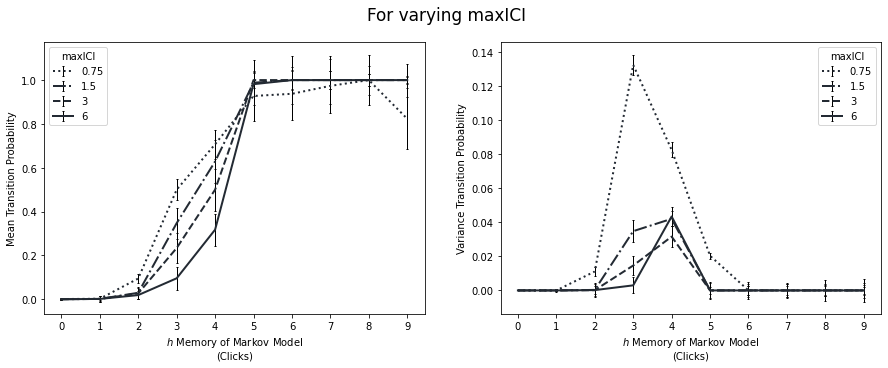

In [180]:
plt.figure(figsize=(15,5))
for i,label,series in zip(range(1,3),['Mean', 'Variance'],[means,variances]):
    plt.subplot(1,2,i)
    
    for values,resolution,linestyle in zip(series,[0.75,1.5,3,6],[':','-.','--','-']):

        plt.errorbar(depths-1, np.nanmedian(values,axis=1), yerr = np.nanvar(values,axis=1),
                     capsize=1, ecolor='k',elinewidth=1,linewidth=2,color=colors['dark'],
                     label=np.round(resolution,3),linestyle=linestyle)
        
    plt.xticks(depths-1)
    plt.legend(title='maxICI')
    plt.ylabel(f'{label} Transition Probability')
    plt.xlabel('$h$ Memory of Markov Model\n(Clicks)')
plt.suptitle('For varying maxICI \n',fontsize=17)
plt.show()

## Number of unique words and skipped blocks

In [199]:
words,skipped=[],[]
for horizon_ in [0.75,1.5,3,6]:
    inner_words,inner_skipped=[],[]
    for depth in depths:
    
        model = MCM(depth=depth,horizon=horizon_,whale=whale).fit(clicks)
        inner_words.append(len(model.nodes))
        inner_skipped.append(model.skipped)
    words.append(inner_words)
    skipped.append(inner_skipped)

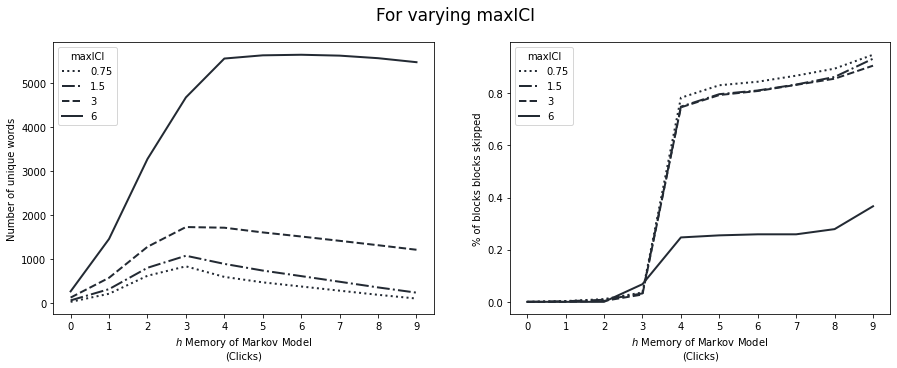

In [202]:
plt.figure(figsize=(15,5))
for i,label,series in zip(range(1,3),['Number of unique words', '% of blocks blocks skipped'],[words,skipped]):
    plt.subplot(1,2,i)
    
    for values,resolution,linestyle in zip(series,[0.75,1.5,3,6],[':','-.','--','-']):
        
         plt.plot(depths-1,values,label=np.round(resolution,3),
                 color=colors['dark'],linestyle=linestyle,linewidth=2)
  
    plt.xticks(depths-1)
    plt.legend(title='maxICI')
    plt.ylabel(f'{label}')
    #plt.yscale('log')
    plt.xlabel('$h$ Memory of Markov Model\n(Clicks)')
plt.suptitle('For varying maxICI \n',fontsize=17)
plt.show()